# UniverSeg: Universal Medical Image Segmentation

This colab notebook is tutorial and demonstration of various aspects of [UniverSeg](https://universeg.csail.mit.edu/).

For demonstration, we employ two datasets, [WBC](https://github.com/zxaoyou/segmentation_WBC) and [OASIS](https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md)

For more information about UniverSeg please visit the website.

> For GPU acceleration go to Edit > Notebook Settings  and for Hardware Accelerator select GPU




## 1. Setup

First, we clone the UniverSeg repo and install necessary dependencies

In [1]:
!git clone https://github.com/JJGO/UniverSeg
!python -m pip install -r ./UniverSeg/requirements.txt

fatal: destination path 'UniverSeg' already exists and is not an empty directory.


In [2]:
import math
import itertools

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import einops as E

Prepare `universeg`: import, setup GPU, and load model

In [3]:
import sys
sys.path.append('UniverSeg')

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from universeg import universeg
model = universeg(pretrained=True)
_ = model.to(device)

Prepare a quick helpful function for visualizing data for this tutorial

In [4]:
def visualize_tensors(tensors, col_wrap=8, col_names=None, title=None):
    M = len(tensors)
    N = len(next(iter(tensors.values())))

    cols = col_wrap
    rows = math.ceil(N/cols) * M

    d = 2.5
    fig, axes = plt.subplots(rows, cols, figsize=(d*cols, d*rows))
    if rows == 1:
      axes = axes.reshape(1, cols)

    for g, (grp, tensors) in enumerate(tensors.items()):
        for k, tensor in enumerate(tensors):
            col = k % cols
            row = g + M*(k//cols)
            x = tensor.detach().cpu().numpy().squeeze()
            ax = axes[row,col]
            if len(x.shape) == 2:
                ax.imshow(x,vmin=0, vmax=1, cmap='gray')
            else:
                ax.imshow(E.rearrange(x,'C H W -> H W C'))
            if col == 0:
                ax.set_ylabel(grp, fontsize=16)
            if col_names is not None and row == 0:
                ax.set_title(col_names[col])

    for i in range(rows):
        for j in range(cols):
            ax = axes[i,j]
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    if title:
        plt.suptitle(title, fontsize=20)

    plt.tight_layout()

In [5]:
# Dice metric for measuring volume agreement
def dice_score(y_pred: torch.Tensor, y_true: torch.Tensor) -> float:
    y_pred = y_pred.long()
    y_true = y_true.long()
    score = 2*(y_pred*y_true).sum() / (y_pred.sum() + y_true.sum())
    return score.item()

In [6]:
import torch.nn as nn

# Define a negative Dice loss to be minimized
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, y_pred, y_true):
        return 1 - dice_score(y_pred, y_true)

In [7]:
# run inference and compute losses for one test image
def inference(model, image, label, support_images, support_labels):
    # image, label = image.to(device), label.to(device)

    # inference
    logits = model(
        image[None],
        support_images[None],
        support_labels[None]
    )[0] # outputs are logits

    soft_pred = torch.sigmoid(logits)
    hard_pred = soft_pred.round().clip(0,1)

    #  score
    score = dice_score(hard_pred, label)

    dice_loss = DiceLoss()


    # return a dictionary of all relevant variables
    return {'Image': image,
            'Logits': logits,
            'Loss': torch.tensor(dice_loss(hard_pred, label), requires_grad=True),
            'Soft Prediction': soft_pred,
            'Prediction': hard_pred,
            'Ground Truth': label,
            'score': score}

# 1. Test inference on KVASIR image seg dataset

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
import os
import numpy as np
import cv2
import torch
from torchvision import transforms
from PIL import Image
from collections import defaultdict
from torch.utils.data import random_split, DataLoader, TensorDataset

folder_name = '/content/gdrive/MyDrive/Kvasir-SEG/'

imagenames = os.listdir(folder_name + 'images')

kvasir_dataset = []
for imgname in imagenames:
  with open(f'/content/gdrive/MyDrive/Kvasir-SEG/images/{imgname}', 'r') as images_file, open(f"/content/gdrive/MyDrive/Kvasir-SEG/masks/{imgname}", 'r')  as masks_file:
    kvasir_dataset.append((images_file, masks_file))

# split dataset
#n_support = 40

### CONVERT ####
convert_tensor = transforms.ToTensor()

kvasir_images = []
kvasir_labels = []

for i in range(len(kvasir_dataset)):
    img = Image.open(kvasir_dataset[i][0].name)
    seg_mask = Image.open(kvasir_dataset[i][1].name)

    # Resize
    img = img.resize((128, 128))
    seg_mask = seg_mask.resize((128, 128))

    # Convert to grayscale
    img = img.convert("L")
    seg_mask = seg_mask.convert("L")

    tensor_img = convert_tensor(img)
    tensor_lbl = convert_tensor(seg_mask)

    kvasir_images.append(tensor_img)
    kvasir_labels.append(tensor_lbl)

# Convert lists to PyTorch tensors
kvasir_images = torch.stack(kvasir_images)
kvasir_labels = torch.stack(kvasir_labels)

# Combine images and labels into a TensorDataset
kvasir_dataset = TensorDataset(kvasir_images, kvasir_labels)

### CONVERT ####

# Define the sizes for training, testing, and validation sets
total_size = len(kvasir_dataset)
train_size = int(0.8 * total_size)
test_size = int(0.1 * total_size)
val_size = total_size - train_size - test_size

# Use random_split to create datasets for training, testing, and validation
train_dataset, test_dataset, val_dataset = random_split(kvasir_dataset, [train_size, test_size, val_size])

# set batch size
batch_size = 64
# Create DataLoaders for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


print(f"training set size: {len(train_loader.dataset)},", f"validation set size: {len(test_loader.dataset)},", f"testing set size: {len(val_loader.dataset)}")
print(f"dataset size: {len(kvasir_dataset)}")

training set size: 800, validation set size: 100, testing set size: 100
dataset size: 1000





# Training



In [10]:
print(train_loader)
task_batch = next(iter(train_loader))
print(task_batch[0].size())

torch.Size([64, 1, 128, 128])


epochs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores: [0.5572803170921711, 0.5644887383454121, 0.5679815190915878, 0.5568985781417444, 0.562894700668179, 0.5539799871353003, 0.5631119826665292, 0.5532889420596453, 0.5641003622171971, 0.555894288019492]


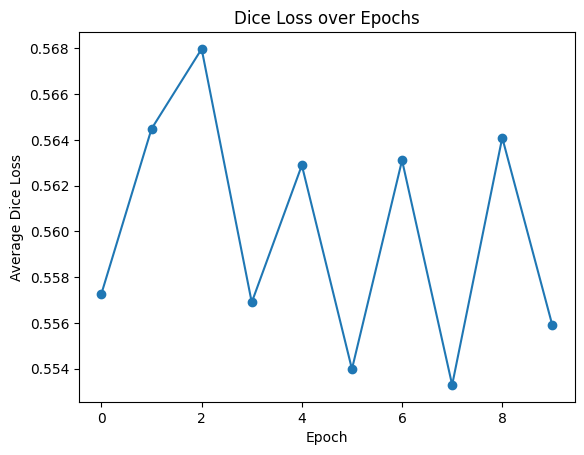

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict

# Assuming you have implemented the UniverSeg model class
model = universeg(pretrained=True)
_ = model.to(device)
model.train()

# # Set the device (GPU or CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# Define optimizer and learning rate
optimizer = optim.SGD(model.parameters(), lr=0.0001)

def Lseg(y_pred, y_true):
    # Ensure that y_true is a long tensor (containing class indices)
    y_true = y_true.long()

    # Calculate the cross-entropy loss
    criterion = nn.CrossEntropyLoss()
    loss = criterion(y_pred, y_true)

    return loss

# Define training loop
def train_universeg(model, dataloader, optimizer, device, num_epochs, plot_every=1):

    scores = []
    epoch_idxs = []

    for epoch in range(num_epochs):
      model.train()
      epoch_loss = 0
      counter = 0
      for batch_idx, (images, labels) in enumerate(dataloader):
        support_images, support_labels = images[32:], labels[32:]
        # Move data to device
        support_images, support_labels = support_images.to(device), support_labels.to(device)
        for i in range(32):
          query_image, query_label = images[i], labels[i]
          query_image, query_label = query_image.to(device), query_label.to(device)

          # Forward pass
          results = inference(model, query_image, query_label, support_images, support_labels)

          logits = results['Logits']

          # Compute segmentation loss
          loss = results['Loss']
          epoch_loss += loss.item()
          counter += 1
          # print(f"\n loss: {loss}")

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      if epoch % plot_every == 0:
        avg_epoch_dice = epoch_loss / counter
        scores.append(avg_epoch_dice)
        epoch_idxs.append(epoch)

    plt.plot(epoch_idxs, scores, marker='o')
    print(f"epochs: {epoch_idxs}")
    print(f"scores: {scores}")

    plt.xlabel('Epoch')
    plt.ylabel('Average Dice Loss')
    plt.title('Dice Loss over Epochs')
    plt.show()

# Example usage
n_epochs = 10  # Adjust based on your dataset size and training preferences

# train_dataloader = DataLoader(kvasir_train, batch_size=batch_size, shuffle=True)

train_universeg(model, train_loader, optimizer, device, n_epochs, plot_every=1)



average test set loss: 0.6271148547530174
average test set dice score: 0.3728851436790137


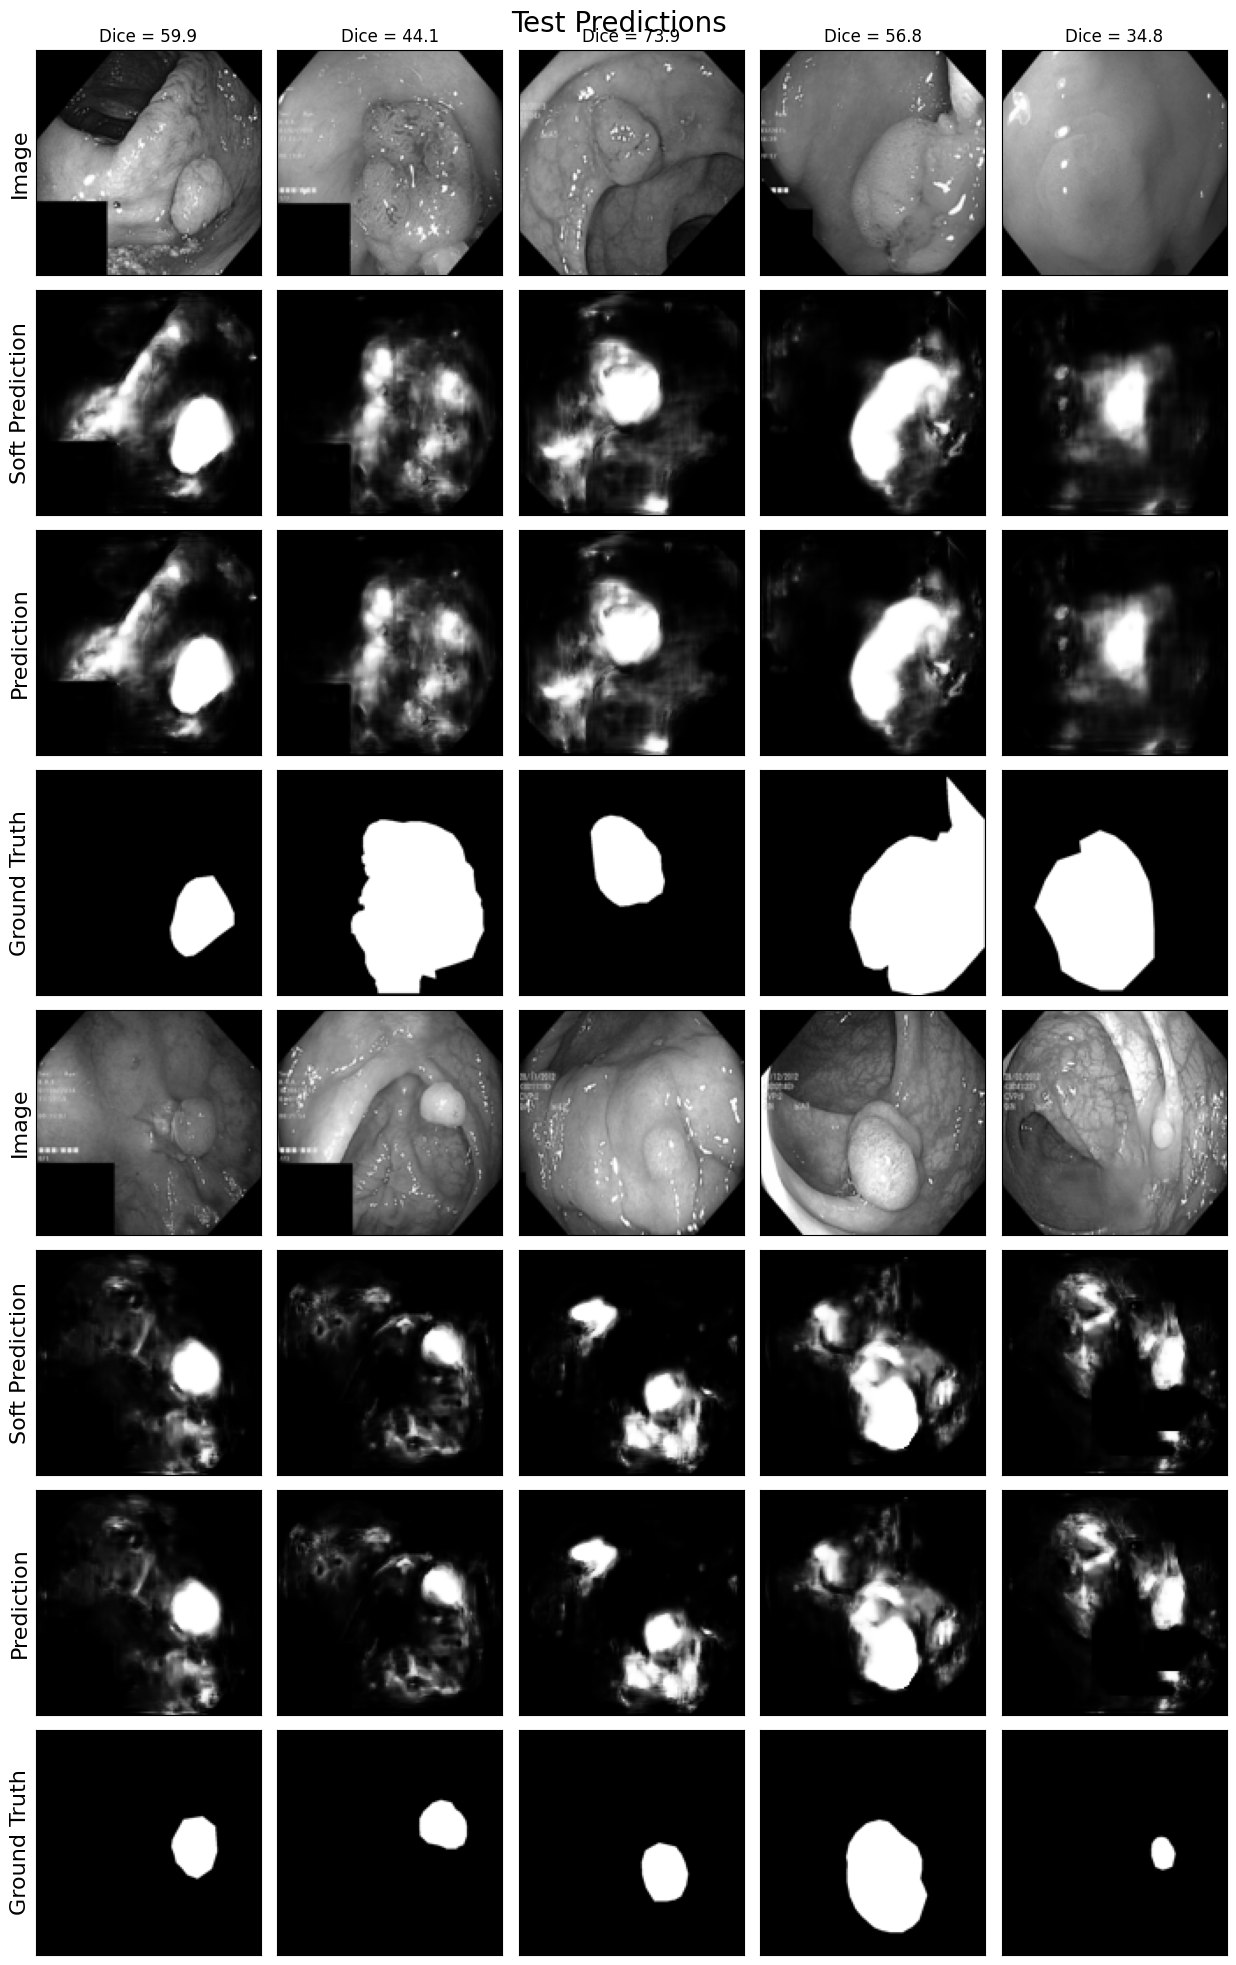

In [12]:
# test inference using newly trained model
# weights_path = 'trained_model_weights.pth'
# loaded_model = torch.load(weights_path)
from collections import defaultdict
model.eval()

total_score = 0
total_loss = 0
counter = 0
results = defaultdict(list)
scores = []
n_predictions = 5
for batch_idx, (images, labels) in enumerate(test_loader):
  support_images, support_labels = images[32:], labels[32:]
  # Move data to device
  support_images, support_labels = support_images.to(device), support_labels.to(device)
  for i in range(32):
    query_image, query_label = images[i], labels[i]
    query_image, query_label = query_image.to(device), query_label.to(device)

    # Forward pass
    result = inference(model, query_image, query_label, support_images, support_labels)
    if i < 5:
      results['Image'].append(result['Image'])
      results['Soft Prediction'].append(result['Soft Prediction'])
      results['Prediction'].append(result['Soft Prediction'])
      results['Ground Truth'].append(result['Ground Truth'])
      scores.append(result['score'])

    # compute score
    total_score += result['score']

    # Compute segmentation loss
    loss = result['Loss']
    total_loss += loss.item()
    counter += 1


avg_loss = total_loss/counter
avg_score = total_score/counter

print(f"average test set loss: {avg_loss}")
print(f"average test set dice score: {avg_score}")

visualize_tensors(results,
                  col_names=[f'Dice = {100*s:.1f}' for s in scores],
                  title='Test Predictions',
                  col_wrap=n_predictions)

In [13]:
weights_path = 'trained_model_weights.pth'
torch.save(model, weights_path)